### Import dataset

In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error
import sklearn

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations,product
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


### Merge dataset

In [3]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [4]:
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋
testfile = '../../data/test.csv'
test_df = pd.read_csv(testfile)

stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)

In [5]:
# pd.set_option('display.max_row',20)
# pd.set_option('display.max_column',8)
# total_df[['5MA_sent_Neg','5MA_sent_Neu','5MA_sent_Pos','60MA_sent_Neg',
#           '60MA_sent_Neu','60MA_sent_Pos','120MA_sent_Neg','120MA_sent_Neu',
#           '120MA_sent_Pos','5MM_sent_Neg','5MM_sent_Neu','5MM_sent_Pos',
#           '60MM_sent_Neg','60MM_sent_Neu','60MM_sent_Pos','120MM_sent_Neg',
#           '120MM_sent_Neu','120MM_sent_Pos','5MM_topics','60MM_topics',
#           '120MM_topics']].iloc[0:115]

In [6]:
 result_df = pd.DataFrame({
    'data':[0],
    'target':[0],
    'seq_size':[0],
    'pred_size':[0],
    'batch_size':[0],
    'hidden_size':[0],
    'best_val_loss':[0],
    'mean_error_ratio':[0]
})
result_df

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,0,0,0,0,0,0,0,0


In [7]:
best_losses = []
mean_error_ratios = []

datanames = ['total_df']#,'stock_df']

for dataname in datanames:
    ### Choose dataset & Hyperparameter setting
    if dataname=='total_df':
        data = total_df
    else:
        data = stock_df
    MODEL = 'GRU'                 # 'LSTM' / 'GRU' / 'Transformer'
    TARGET = "1d_ROC"                      # "Close" / "1d_ROC"
    SEQ_SIZE = 30                         # 30 / 60 / 120
    PRED_SIZE = 10
    BATCH_SIZE = 1                        # 1 / 4 / 8
    HIDDEN_SIZE = 128                      # 64 / 128
    EPOCHS = 1000
    
    filename = f'{MODEL}_{dataname}_{TARGET}_seq{SEQ_SIZE}_batch{BATCH_SIZE}_hidden{HIDDEN_SIZE}'

    print(f'🔸START - {filename}🔸')
    ### Make train datset

    def split_xy(dataset, time_steps, y_column):
        x, y = list(), list()
        for i in range(len(dataset)):
            x_end_number = i + time_steps
            y_end_number = x_end_number + y_column

            if y_end_number > len(dataset):
                break
            tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
            tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
            x.append(tmp_x.values)  # Convert to numpy array
            y.append(tmp_y.values)  # Convert to numpy array

        return np.array(x), np.array(y)

    X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
#     print(X[0,:],"\n", y[0])
#     print("X size : ", X.shape)
#     print("y size : ", y.shape)

    ### Define X_test

    X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])
#     print(X_test)
#     print("X_test size : ", X_test.shape)

    ### Standardization

    from sklearn.preprocessing import StandardScaler

    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
    X_test = scaler.transform(X_test)
    X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

#     print("X size : ", X.shape)
#     print("X_test size : ", X_test.shape)

    ### Split train-validation dataset

    # to DataLoader
    import torch
    from torch.utils.data import Dataset, DataLoader, TensorDataset
    from sklearn.model_selection import train_test_split

    for trial in tqdm(list(range(1,11))):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

        # to tensor
        X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
        X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
        y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
        y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

        # to DataLoader
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
        val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

        ### Initialize Model
        try:
            for param in model.parameters():
                if param.requires_grad:
                    if len(param.shape) > 1:
                        init.xavier_uniform_(param)
                    else:
                        init.zeros_(param)
        except:
            try:
                model.reset_parameters()
            except:
                pass

        ### Modeling

        import copy
        class EarlyStopping:
            def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
                self.patience = patience
                self.min_delta = min_delta
                self.restore_best_weights = restore_best_weights
                self.best_model = None
                self.best_loss = None
                self.counter = 0
                self.status = ""

            def __call__(self, model, val_loss):
                if self.best_loss is None:
                    self.best_loss = val_loss
                    self.best_model = copy.deepcopy(model.state_dict())
                elif self.best_loss - val_loss >= self.min_delta:
                    self.best_model = copy.deepcopy(model.state_dict())
                    self.best_loss = val_loss
                    self.counter = 0
                    self.status = f"Improvement found, counter reset to {self.counter}"
                else:
                    self.counter += 1
                    self.status = f"No improvement in the last {self.counter} epochs"
                    if self.counter >= self.patience:
                        self.status = f"Early stopping triggered after {self.counter} epochs."
                        if self.restore_best_weights:
                            model.load_state_dict(self.best_model)
                        return True
                return False

        class GRUModel(nn.Module):
            def __init__(self,input_dim,HIDDEN_SIZE):
                super(GRUModel,self).__init__()
                self.lstm = nn.LSTM(input_dim, hidden_size = HIDDEN_SIZE, batch_first = True)
                self.dropout = nn.Dropout(0.2)
                self.seq = nn.Sequential(nn.Linear(HIDDEN_SIZE, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, PRED_SIZE)
                                        )

            def forward(self,x):
                x,_ = self.lstm(x)
        #         print('output of lstm :',x.size()) # torch.Size([1, 120, 64])
                x = self.dropout(x[:,-1,:])
        #         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
                x = self.seq(x)
                return x

        class RMSELoss(nn.Module):
            def __init__(self):
                super(RMSELoss,self).__init__()
                self.mse = nn.MSELoss()

            def forward(self,yhat,y):
                return torch.sqrt(self.mse(yhat,y))

        globals()[f'model{trial}'] = GRUModel(X_train.shape[2],HIDDEN_SIZE).to(device)
        criterion = RMSELoss()
        optimizer = optim.Adam(globals()[f'model{trial}'].parameters(), lr = 0.001)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 20, verbose = True)

        ### RUN!!

        epoch_counter = 0
        patience = 30
        best_loss = float('inf')
        done = False
        es = EarlyStopping(patience=patience)
        tr_losses_fp, val_losses_fp = [],[]

        while not done and epoch_counter<EPOCHS:
            epoch_counter+=1

            # train
            globals()[f'model{trial}'].train()
            train_losses = []
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                output = globals()[f'model{trial}'](x_batch)
                loss = criterion(output,y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            train_loss = np.mean(train_losses)
            tr_losses_fp.append(train_loss)

            # validation
            globals()[f'model{trial}'].eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    x_batch, y_batch = batch
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = globals()[f'model{trial}'](x_batch)
                    loss = criterion(output, y_batch)
                    val_losses.append(loss.item())
            val_loss = np.mean(val_losses)
            val_losses_fp.append(val_loss)
            scheduler.step(val_loss)

            if es(globals()[f'model{trial}'], val_loss):
                done = True

            if val_loss < best_loss:
                best_loss = val_loss

            if epoch_counter%20 == 0:
                print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        print(f"Best validation loss : {best_loss}")
        best_losses.append(best_loss)
        
        ### Visualize train-validation loss

#         plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
#         plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
#         plt.legend()
#         # plt.show()
#         plt.savefig(f'../../plots/train_val_loss_2/{filename}.png')
#         plt.clf()
        globals()[f'train_losses_{trial}']=tr_losses_fp
        globals()[f'val_losses_{trial}']=val_losses_fp

        ### Prediction

        # evaluation
        globals()[f'model{trial}'].eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype = torch.float32,device=device)
            pred = globals()[f'model{trial}'](X_test_tensor)

        pred = pred.to('cpu').detach().numpy()
        # print(pred)

        if TARGET == "1d_ROC" :
            endPrice = data['Close'].iloc[-1]
            pred_close = []

            for i in pred[0] :
                endPrice = endPrice + endPrice*0.01*i
                pred_close.append(endPrice)

            pred = np.array(pred_close).reshape(1, PRED_SIZE)
        #     pred
        else :
            pass

        globals()[f'pred_{trial}'] = pred
        
        # pred_length = len(np.reshape(pred, (-1)))
        # pred_indices = list(range(pred_length))
        # plt.plot(pred_indices, np.reshape(pred, (-1)), color='red', alpha=0.6, label='Prediction')
        # plt.legend()

        # plt.show()

        ### Evaluation

        # Label
#         testfile = '../../data/test.csv'
#         test_df = pd.read_csv(testfile)
#         label = pd.read_csv(testfile) # 각자 test.csv 파일 경로
        label = test_df.copy()
        label = np.array(label.head(PRED_SIZE)["Close Price"])

        # Prediction
        pred = np.array(pred).reshape(PRED_SIZE)

        # 날짜 데이터
        period = test_df["Date"].copy()
        period = [d for d in period.head(PRED_SIZE)]

        # 오차율 계산
        error_rate = np.abs((label - pred) / label) * 100

        # 시각화
#         plt.figure(figsize=(12, 6))
#         plt.plot(period, label, marker='o', color='blue', label='Actual Close Price')
#         plt.plot(period, pred, marker='x', color='red', linestyle='--', label='Predicted Close Price')

#         # 오차율을 각 포인트에 텍스트로 표시
#         for date, lbl, prd, err in zip(period, label, pred, error_rate):
#             plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

#         plt.xticks(rotation = 45)  # 날짜 레이블 회전
#         plt.xlabel('Date')
#         plt.ylabel('Close Price')
#         plt.title(f'model = LSTM, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
#         plt.legend()
#         plt.tight_layout()  # 레이아웃 조정
#         # plt.show()
#         plt.savefig(f'../../plots/results_2/{filename}.png')
#         plt.clf()

        # 오차율을 출력
        error_rate_dict = dict(zip(period, error_rate))
        # error_rate_dict

        # 평균 오차율 계산
        average_error_rate = np.mean(error_rate)
        
        print(f"Average Error Rate: {average_error_rate:.2f}%")
        mean_error_ratios.append(average_error_rate)
        
        ### Save results to a DataFrame
#         temp_df = pd.DataFrame({
#             'data':[dataname],
#             'target':[TARGET],
#             'seq_size':[SEQ_SIZE],
#             'pred_size':[PRED_SIZE],
#             'batch_size':[BATCH_SIZE],
#             'hidden_size':[HIDDEN_SIZE],
#             'best_val_loss':[best_loss],
#             'mean_error_ratio':[average_error_rate]
#         })

#         result_df = pd.concat([result_df,temp_df],axis=0)
print('🔸END🔸')

🔸START - GRU_total_df_1d_ROC_seq30_batch1_hidden128🔸


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 2.3953, Validation Loss: 2.2170
Epoch 40/1000, Train Loss: 2.2581, Validation Loss: 2.1539
Epoch 60/1000, Train Loss: 2.1461, Validation Loss: 2.1548
Epoch 00076: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 1.9940, Validation Loss: 2.1364


 10%|████████                                                                        | 1/10 [12:16<1:50:30, 736.72s/it]

Best validation loss : 2.1084636229960645
Average Error Rate: 2.00%
Epoch 20/1000, Train Loss: 2.3425, Validation Loss: 2.1935
Epoch 40/1000, Train Loss: 2.1908, Validation Loss: 2.1071
Epoch 60/1000, Train Loss: 2.0579, Validation Loss: 2.1425
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.


 20%|████████████████                                                                | 2/10 [24:09<1:36:21, 722.66s/it]

Best validation loss : 2.0965962341574373
Average Error Rate: 1.31%
Epoch 20/1000, Train Loss: 2.3757, Validation Loss: 2.2015
Epoch 40/1000, Train Loss: 2.2028, Validation Loss: 2.1004
Epoch 60/1000, Train Loss: 2.0755, Validation Loss: 2.1380
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.


 30%|████████████████████████                                                        | 3/10 [36:05<1:23:57, 719.65s/it]

Best validation loss : 2.091556024600248
Average Error Rate: 2.62%
Epoch 20/1000, Train Loss: 2.3461, Validation Loss: 2.1706
Epoch 40/1000, Train Loss: 2.2057, Validation Loss: 2.1211
Epoch 60/1000, Train Loss: 2.0507, Validation Loss: 2.1420
Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.


 40%|████████████████████████████████                                                | 4/10 [45:46<1:06:28, 664.69s/it]

Best validation loss : 2.107909241904978
Average Error Rate: 2.20%
Epoch 20/1000, Train Loss: 2.3580, Validation Loss: 2.1891
Epoch 40/1000, Train Loss: 2.1636, Validation Loss: 2.0747
Epoch 60/1000, Train Loss: 2.0321, Validation Loss: 2.1186
Epoch 00061: reducing learning rate of group 0 to 1.0000e-04.


 50%|█████████████████████████████████████████                                         | 5/10 [54:18<50:48, 609.67s/it]

Best validation loss : 2.0746832416682945
Average Error Rate: 2.15%
Epoch 20/1000, Train Loss: 2.3315, Validation Loss: 2.1730
Epoch 40/1000, Train Loss: 2.1910, Validation Loss: 2.1273
Epoch 60/1000, Train Loss: 2.0705, Validation Loss: 2.1183
Epoch 00062: reducing learning rate of group 0 to 1.0000e-04.


 60%|████████████████████████████████████████████████                                | 6/10 [1:02:57<38:35, 578.95s/it]

Best validation loss : 2.077271385759604
Average Error Rate: 3.50%
Epoch 20/1000, Train Loss: 2.3623, Validation Loss: 2.1955
Epoch 40/1000, Train Loss: 2.1945, Validation Loss: 2.1164
Epoch 60/1000, Train Loss: 2.0696, Validation Loss: 2.1187
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.


 70%|████████████████████████████████████████████████████████                        | 7/10 [1:12:30<28:50, 576.99s/it]

Best validation loss : 2.0979220339509306
Average Error Rate: 4.40%
Epoch 20/1000, Train Loss: 2.3792, Validation Loss: 2.1946
Epoch 40/1000, Train Loss: 2.2309, Validation Loss: 2.1477
Epoch 60/1000, Train Loss: 2.0915, Validation Loss: 2.1550
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:21:44<18:59, 569.62s/it]

Best validation loss : 2.1182466022303847
Average Error Rate: 2.34%
Epoch 20/1000, Train Loss: 2.3423, Validation Loss: 2.1758
Epoch 40/1000, Train Loss: 2.1982, Validation Loss: 2.1079
Epoch 60/1000, Train Loss: 2.0666, Validation Loss: 2.1057
Epoch 00075: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 1.8784, Validation Loss: 2.1600


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:31:56<09:43, 583.02s/it]

Best validation loss : 2.0895415554281143
Average Error Rate: 1.84%
Epoch 20/1000, Train Loss: 2.3403, Validation Loss: 2.1747
Epoch 40/1000, Train Loss: 2.1972, Validation Loss: 2.1049
Epoch 60/1000, Train Loss: 2.0675, Validation Loss: 2.1130
Epoch 00061: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 1.9325, Validation Loss: 2.0992
Epoch 00088: reducing learning rate of group 0 to 1.0000e-05.


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:44:22<00:00, 626.30s/it]

Best validation loss : 2.0862950792566677
Average Error Rate: 4.07%
🔸END🔸


In [8]:
preds = []
for t in list(range(1,11)):
    preds.append(globals()[f'pred_{t}'].tolist())
preds = np.reshape(np.array(preds),(10,10))
preds

array([[484.92383772, 483.84438275, 485.18684285, 486.66481423,
        486.64866198, 486.02478676, 487.17050165, 491.82916342,
        498.56921935, 502.182556  ],
       [481.39336748, 476.12650119, 472.36461133, 471.79890118,
        473.34163939, 478.33670311, 483.66732453, 489.91702793,
        494.02718643, 495.70886607],
       [483.74497863, 482.73998672, 484.20395637, 487.96836061,
        492.64293291, 495.91736121, 498.54417862, 499.21886139,
        499.7159808 , 499.29764529],
       [487.05401912, 487.12146582, 487.51143271, 488.30761694,
        489.56619637, 490.24950666, 490.92928093, 491.97609799,
        494.21687056, 495.85080571],
       [484.09481817, 479.48524223, 473.28465332, 468.4479456 ,
        465.17341711, 467.30432534, 471.11795193, 475.33301613,
        479.1192786 , 481.15052514],
       [486.72566829, 488.15950587, 491.41781995, 495.98917881,
        499.38392722, 500.87567782, 500.98256705, 500.53777737,
        500.9221681 , 500.72960738],
       [48

In [9]:
preds_df = pd.DataFrame(preds,columns=['model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
preds_df['Mean']=preds_df.mean(axis=1)
preds_df

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,Mean
0,484.923838,483.844383,485.186843,486.664814,486.648662,486.024787,487.170502,491.829163,498.569219,502.182556,489.304477
1,481.393367,476.126501,472.364611,471.798901,473.341639,478.336703,483.667325,489.917028,494.027186,495.708866,481.668213
2,483.744979,482.739987,484.203956,487.968361,492.642933,495.917361,498.544179,499.218861,499.715981,499.297645,492.399424
3,487.054019,487.121466,487.511433,488.307617,489.566196,490.249507,490.929281,491.976098,494.216871,495.850806,490.278329
4,484.094818,479.485242,473.284653,468.447946,465.173417,467.304325,471.117952,475.333016,479.119279,481.150525,474.451117
5,486.725668,488.159506,491.417820,495.989179,499.383927,500.875678,500.982567,500.537777,500.922168,500.729607,496.572390
6,485.118304,485.154081,489.066194,497.142486,504.774553,509.454716,510.518098,509.862343,509.502990,508.962617,500.955638
7,485.413718,483.565192,479.253600,473.775640,469.697303,469.032286,470.212357,472.460666,475.325570,476.762080,475.549841
8,481.993051,478.870699,482.239893,488.022553,490.012950,487.672242,489.525986,494.398346,498.335351,495.519489,488.659056
9,491.543515,498.266895,505.860387,506.852851,503.900403,501.845721,500.466769,498.106992,494.781040,491.057106,499.268168


In [10]:
results_df = pd.DataFrame([best_losses,mean_error_ratios], columns=[
                            'model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
print('Mean Val_Loss :',results_df.iloc[0].mean())
print('Mean Error Ratio :',results_df.iloc[1].mean())
results_df

Mean Val_Loss : 2.0948485021952723
Mean Error Ratio : 2.644101047891295


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
0,2.108464,2.096596,2.091556,2.107909,2.074683,2.077271,2.097922,2.118247,2.089542,2.086295
1,2.000244,1.312226,2.622148,2.202402,2.153575,3.496052,4.395930,2.339926,1.843959,4.074550


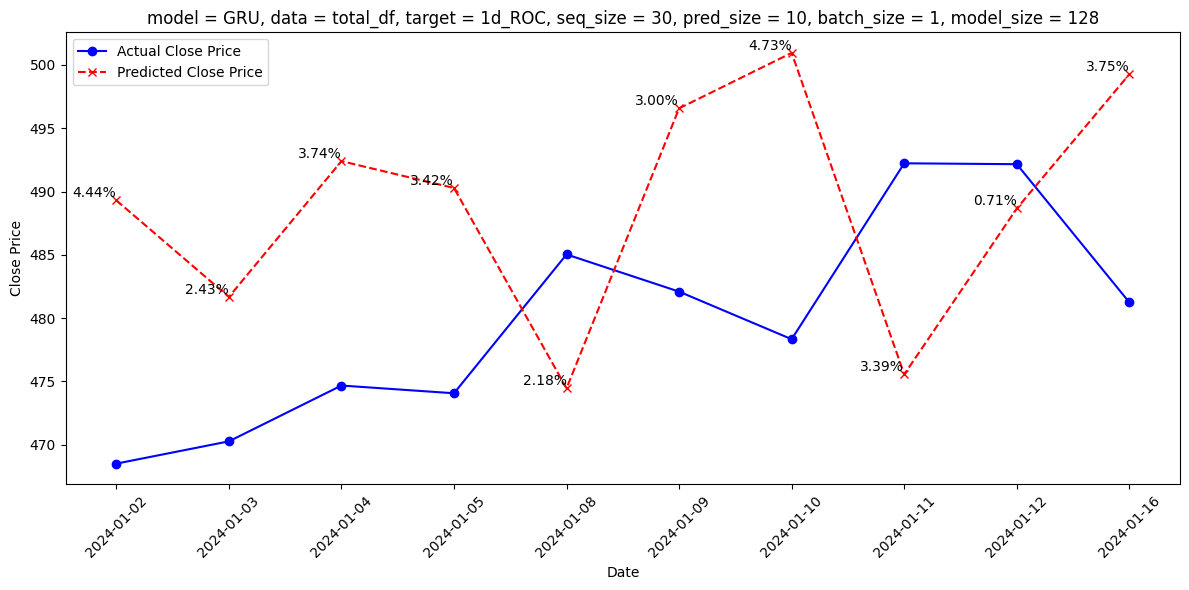

Average Error Rate: 3.18%


<Figure size 640x480 with 0 Axes>

In [11]:
# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(period, label, marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')

# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
# plt.savefig(f'../../plots/best_plots/10trials_{filename}_2.png') #### 본인 파일 경로
plt.show()
plt.clf()

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")
mean_error_ratios.append(average_error_rate)

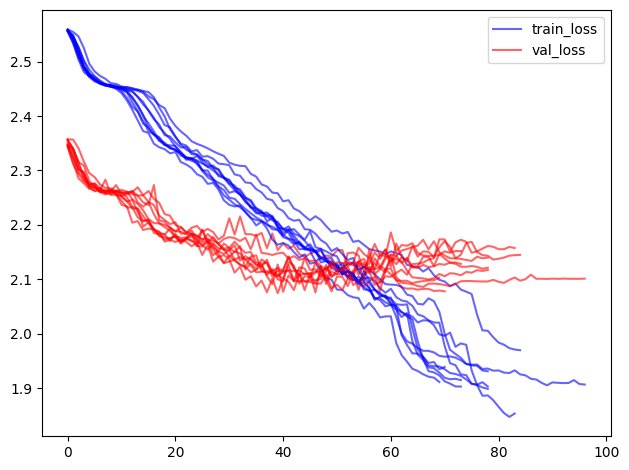

<Figure size 640x480 with 0 Axes>

In [12]:
### Visualize train-validation loss

for t in list(range(1,11)):
    plt.plot(range(len(globals()[f'train_losses_{t}'])),
             globals()[f'train_losses_{t}'],
             color='blue',alpha=0.6)
    plt.plot(range(len(globals()[f'val_losses_{t}'])),
             globals()[f'val_losses_{t}'],
             color='red',alpha=0.6)
plt.legend(['train_loss','val_loss'])
plt.tight_layout()
# plt.savefig(f'../../plots/best_plots/10trials_train_val_loss_{filename}_2.png')
plt.show()
plt.clf()